# PROJECT: SKIMLIT

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-510e2ab0-5499-ebfb-88b4-a56d20573b06)


##Get Data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 34.43 MiB/s, done.
Resolving deltas: 100% (12/12), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
#check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
!ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [ ]:
#Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"


In [ ]:
#check all the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtrain.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signdev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtest.txt']

## Preprocess data

In [ ]:
#create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
  filenames: a string containing the target filepath.

  Returns
  A list os strings with one string per line from the target filename.
  """
  with open(filename,"r") as f:
    return f.readlines()


In [ ]:
#Lets read in the training lines
train_lines = get_lines("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt")

In [ ]:
len(train_lines)

210040

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data

  Takes in filename, reads it contents and sorts through each line
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) #  get all lines
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] #create an empty list of abstracts

  #Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the is an ID line
      abstract_id = line
      abstract_lines = "" #reset the abstract string if the line is an ID line
    elif line.isspace(): #check yo see if the line is new line
      abstract_line_split = abstract_lines.splitlines() #split abstract into seperate lines


      #Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} #create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split the target label from text
        line_data["line_number"] = abstract_line_number # what number line does the line appear in
        line_data["target"]=target_text_split[0] #get the target label
        line_data["text"] = target_text_split[1].lower() #get target text and lower it
        line_data["total_lines"] = len(abstract_line_split)-1  #How many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    else: #if the above conditions are not fullfilled the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
#Get data from file and pre-process it
%%time
train_samples = preprocess_text_with_line_numbers("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt")
val_samples = preprocess_text_with_line_numbers("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt")
test_samples = preprocess_text_with_line_numbers("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 434 ms, sys: 77.7 ms, total: 511 ms
Wall time: 513 ms


(180040, 30212, 30135)

In [ ]:
#check the abstract of training data
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


In [ ]:
# Distribution of labels in the training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

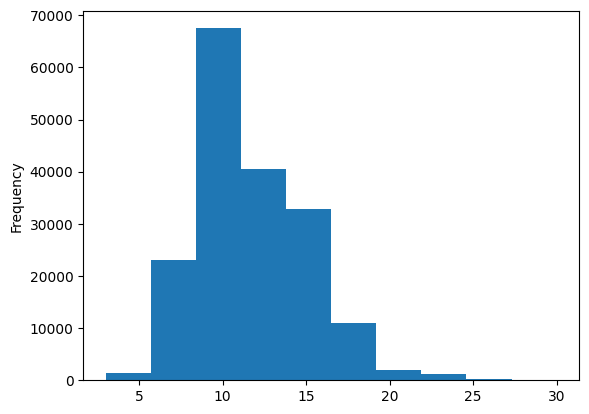

In [ ]:
# Lets check the length of different lines
train_df.total_lines.plot.hist();

###Get lists of sentences

In [ ]:
#convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

##Make numeric labels

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))
#check what one hot encoded labels look
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

###Label encode labels

In [ ]:
#Extract  labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

##Model 0: Baseline model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

#Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)


0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

###Download helper function script

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-29 18:16:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2023-08-29 18:16:11 (15.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                               y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

##Preparing the data (the text) for Deep Sequence Models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
#How long is the each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

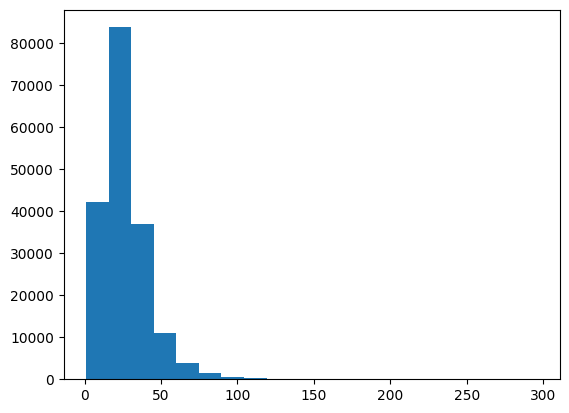

In [ ]:
# whats the distribution look like
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [ ]:
# How long is each sentences on average look like?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Maximum sequnce length in traing set
max(sent_lens)

296

###Create Text Vectorizer layer

To make a layer which maps our texts from words to numbers.

In [ ]:
# How many words there in the vocab?
max_tokens = 68000

In [ ]:
#create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens = max_tokens, # no of words in vocabulary
                                    output_sequence_length = output_seq_len) #desired output length of vectorized sequence

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
mean in-stent lumen loss was @ @ mm for pf-pes and @ @ mm for pb-pes ( p < @ ) .

Length of text: 80

Vectorized text: [[   57  7205  4319   264    10   234    11 15610     3   234    11 16780
     14     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of wordsin vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of wordsin vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

###Create custom text embedding

In [ ]:
#create token embedding layer
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim = 128, #Note: different embedding sizes result in drastically differwent numbers of parameters
                               mask_zero = True, # use masking to handle variable sequence lengths (save space),
                               name="token_embedding")

In [ ]:
#show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before the embedding):\n {vectorized_sentence}\n")
embedded_sentence =token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 mean in-stent lumen loss was @ @ mm for pf-pes and @ @ mm for pb-pes ( p < @ ) .

Sentence after vectorization (before the embedding):
 [[   57  7205  4319   264    10   234    11 15610     3   234    11 16780
     14     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[ 0.01605636 -0.0027989   0.03044834 ...  0.01412941 -0.01876709
    0.03506075]
  [-0.01317668  0.04842389 -0.02404656 ... -0.01707902 -0.03130569
   -0.03972505]
  [ 0.01256621 -0.0336751  -0.02687465 ... -0.00758182  0.01230939
   -0.00108503]
  ...
  [ 0.04420005  0.00390645  0.00627426 ...  0.04176507  0.03045204
    0.0287366 ]
  [ 0.04420005  0.00390645  0.00627426 ...  0.04176507  0.03045204
    0.0287366 ]
  [ 0.04420005  0.00390645  0.00627426 ..

##Creating Datasets

Setup the data to run as fast as possible with the TensorFlow tf.data API

In [ ]:
#Turn our data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
#Take the tesnorflow slices into batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

##Model 1: Conv1D with Token Embeddings

In [ ]:
#create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype="string")
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) #create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 =tf.keras.Model(inputs, outputs)

#compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
#Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))) #only validate on 10% of the data

Epoch 1/3
562/562 [==============================] - 45s 61ms/step - loss: 0.9228 - accuracy: 0.6323 - val_loss: 0.6885 - val_accuracy: 0.7364
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.6576 - accuracy: 0.7553 - val_loss: 0.6327 - val_accuracy: 0.7699
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.6162 - accuracy: 0.7733 - val_loss: 0.5985 - val_accuracy: 0.7859


In [ ]:
#Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5986 - accuracy: 0.7867


[0.5986372232437134, 0.7867403626441956]

In [ ]:
#Make predictions (Model's prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[4.6343833e-01, 1.6265717e-01, 6.5033339e-02, 2.8622562e-01,
         2.2645583e-02],
        [3.5081467e-01, 3.8223338e-01, 1.1259858e-02, 2.4562304e-01,
         1.0069063e-02],
        [1.6995406e-01, 1.0105041e-02, 2.1229982e-03, 8.1777531e-01,
         4.2694883e-05],
        ...,
        [6.1767337e-06, 7.9739973e-04, 6.5624760e-04, 2.6389948e-06,
         9.9853754e-01],
        [5.6938529e-02, 4.9040252e-01, 9.9559039e-02, 6.4886048e-02,
         2.8821385e-01],
        [1.9199692e-01, 6.3155133e-01, 4.3903470e-02, 7.6778375e-02,
         5.5769887e-02]], dtype=float32),
 (30212, 5))

In [ ]:
#convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.67403680656693,
 'precision': 0.7841018329667554,
 'recall': 0.7867403680656693,
 'f1': 0.7843910465811459}

##Model 2: TensorFlow Hub Pretrained Feature Extractor

In [ ]:
#Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                       trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
#Test our pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentences:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentences:
 as hypothesised , receiving opv@ + bcg versus bcg alone was associated with significantly lower prevalence of ifn - responses to ppd ( prevalence ratio ( pr ) : @ ( @-@ @ ) ) and reduced il-@ to ppd ( pr : @ ( @-@ @ ) ) .
Sentence after embedding:
 [-0.05274365  0.0269846  -0.02281193 -0.06371585  0.03423587  0.06226077
  0.060785   -0.02134809  0.07208426  0.02087597  0.0355325   0.06161747
 -0.01362846  0.02057321  0.03607537 -0.03433826 -0.07241752 -0.01228525
  0.01853087  0.05683227  0.02660402  0.04429525 -0.04654361  0.05900976
  0.06515368  0.06438347 -0.04492156 -0.06722375  0.07248224  0.06589059]

Length of sentence embedding: 512


###Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub

In [ ]:
#Deine feature extraction using TF hub layer
inputs = layers.Input(shape=[], dtype="string")
pretrained_embedding = tf_hub_embedding_layer(inputs) #tokenize text and create numbers
x= layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_2 = tf.keras.Model(inputs=inputs,
                         outputs = outputs,
                         name="model_2_USE_feature_extractor")

#Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
#Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 16ms/step - loss: 0.9141 - accuracy: 0.6490 - val_loss: 0.7955 - val_accuracy: 0.6892
Epoch 2/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7675 - accuracy: 0.7016 - val_loss: 0.7537 - val_accuracy: 0.7035
Epoch 3/3
562/562 [==============================] - 8s 13ms/step - loss: 0.7507 - accuracy: 0.7123 - val_loss: 0.7376 - val_accuracy: 0.7118


In [ ]:
#Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 12s 13ms/step - loss: 0.7402 - accuracy: 0.7141


[0.74020916223526, 0.7140540480613708]

In [ ]:
#Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 11s 11ms/step


array([[4.5173034e-01, 3.3970442e-01, 2.1783775e-03, 1.9892600e-01,
        7.4608894e-03],
       [3.5115916e-01, 4.9449471e-01, 3.6147549e-03, 1.4818224e-01,
        2.5491987e-03],
       [2.3339538e-01, 1.6055417e-01, 1.4224621e-02, 5.5690384e-01,
        3.4921929e-02],
       ...,
       [1.7292986e-03, 7.1986117e-03, 5.6238048e-02, 7.4328278e-04,
        9.3409079e-01],
       [4.8000221e-03, 4.9219608e-02, 2.0205756e-01, 1.4200025e-03,
        7.4250281e-01],
       [1.6443606e-01, 2.6242220e-01, 4.9773568e-01, 8.0471430e-03,
        6.7358918e-02]], dtype=float32)

In [ ]:
#Convert the prediction probabilities found with feature ectraction model to label
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
#calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 71.40540182708858,
 'precision': 0.7143512241969813,
 'recall': 0.7140540182708858,
 'f1': 0.711138491752075}

##Model 3: Conv 1D with Character Embeddings

###Create a character level Tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# " ".join(list(text)) -------> splits sentences into characters

In [ ]:
#Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

#Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'a s   h y p o t h e s i s e d   ,   r e c e i v i n g   o p v @   +   b c g   v e r s u s   b c g   a l o n e   w a s   a s s o c i a t e d   w i t h   s i g n i f i c a n t l y   l o w e r   p r e v a l e n c e   o f   i f n   -   r e s p o n s e s   t o   p p d   (   p r e v a l e n c e   r a t i o   (   p r   )   :   @   (   @ - @   @   )   )   a n d   r e d u c e d   i l - @   t o   p p d   (   p r   :   @   (   @ - @   @   )   )   .'

In [ ]:
#Split sequence-level data splits into charcater-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
#Whats the average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

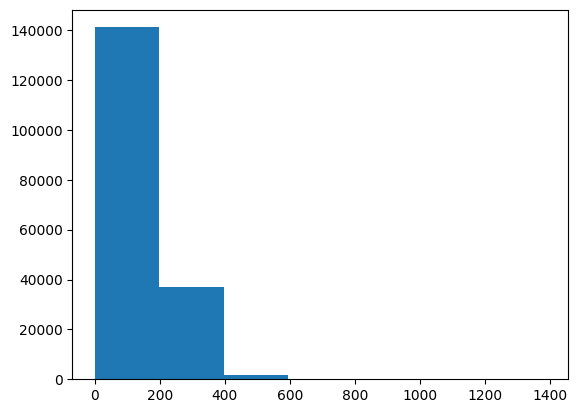

In [ ]:
#Check the distribution of sequences in the character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [ ]:
#Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
#Get all the keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
#create char-level token vectonizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 #add 2 dor space and OOV token(oov = out of vocab token, '[UNK]')
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    #standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [ ]:
#Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Nnumber of different characters in characters vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Nnumber of different characters in characters vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
#Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars)}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\Vectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 a l l   s e s s i o n s   w e r e   a u d i o t a p e d   f o r   c o n t e n t   a n a l y s i s   .

Length of random_train_chars: 101
\Vectorized chars:
 [[ 5 12 12  9  2  9  9  4  7  6  9 20  2  8  2  5 16 10  4  7  3  5 14  2
  10 17  7  8 11  7  6  3  2  6  3  5  6  5 12 19  9  4  9  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  

###Creating a Character level Embedding

In [ ]:
#Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), #no of different characters
                              output_dim = 25, #this the size of the char embedding in the paper
                              mask_zero = True,
                              name="char_embed")

In [ ]:
#Test the character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and Embedding):\n {char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 a l l   s e s s i o n s   w e r e   a u d i o t a p e d   f o r   c o n t e n t   a n a l y s i s   .

Embedded chars. (after vectorization and Embedding):
 [[[-0.03369816  0.03982507  0.00240671 ... -0.04260973  0.01371472
   -0.04906208]
  [-0.014268   -0.04862008  0.01108367 ...  0.02305044  0.03807299
   -0.02005011]
  [-0.014268   -0.04862008  0.01108367 ...  0.02305044  0.03807299
   -0.02005011]
  ...
  [ 0.02546415  0.0052299   0.01174594 ... -0.03361054 -0.01461267
   -0.00111227]
  [ 0.02546415  0.0052299   0.01174594 ... -0.03361054 -0.01461267
   -0.00111227]
  [ 0.02546415  0.0052299   0.01174594 ... -0.03361054 -0.01461267
   -0.00111227]]]
Character embedding shape: (1, 290, 25)


###Building a Conv1D model to fit on character embeddings

In [ ]:
# Make conv1d on chars only
inputs = layers.Input(shape=(1, ), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64,kernel_size = 5, padding = "same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")

#compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

In [ ]:
#Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
#Fit the model on chars only
model_3.history=model_3.fit(train_char_dataset,
                            steps_per_epoch=int(0.1*len(train_char_dataset)),
                            epochs=3,
                            validation_data=val_char_dataset,
                            validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 8ms/step - loss: 1.2989 - accuracy: 0.4815 - val_loss: 1.1150 - val_accuracy: 0.5715
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 1.0578 - accuracy: 0.5716 - val_loss: 0.9750 - val_accuracy: 0.6174
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9603 - accuracy: 0.6212 - val_loss: 0.8960 - val_accuracy: 0.6453


In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)

945/945 [==============================] - 3s 3ms/step


In [ ]:
#Convert prediction probabilities inot product labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
#Calculate results for conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 64.38170263471469,
 'precision': 0.6343411139785707,
 'recall': 0.6438170263471469,
 'f1': 0.6330306611570741}

##Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding)

1. Create a token level embedding.
2. Create a character level model(similar to 'model_3' with slight modification).
3. Combine 1 & 2 with a concatenate ('layers.concatenate').
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of the paper.
5. Construct a model which takes token and character-level sequence as input and produces sequence label probabilities as output.

In [ ]:
# 1. Setup token inputs/model

token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs = token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,),dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) #bi-LSTM shown in the paper
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embbedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

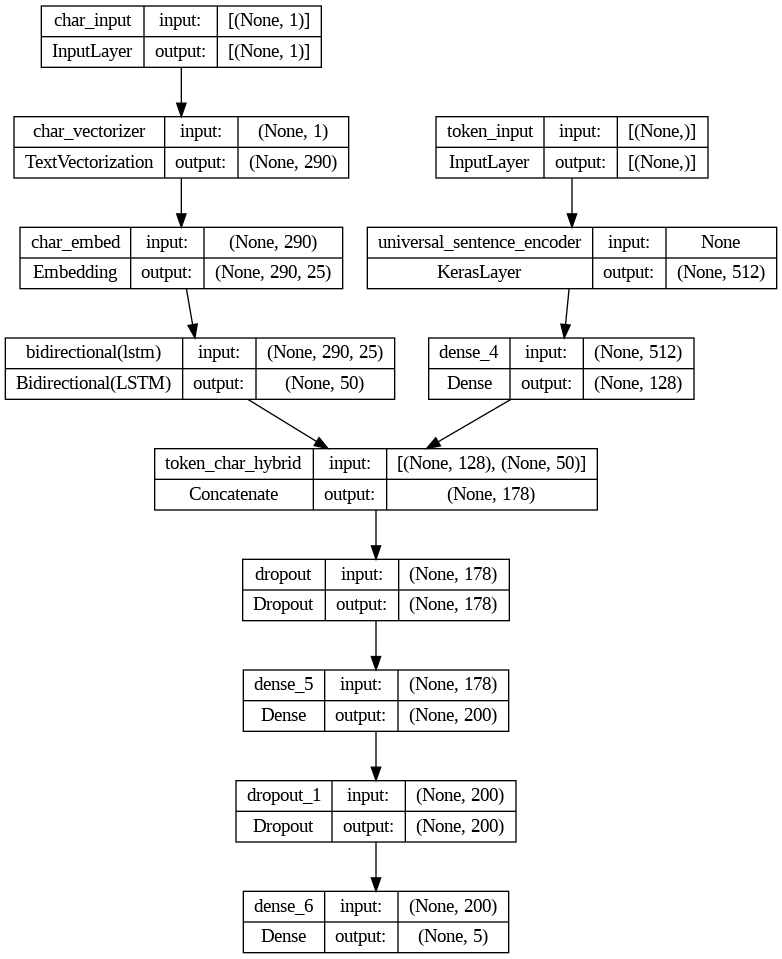

In [ ]:
#Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

###Combining token and character data into a tf.data Dataset

In [ ]:
#Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) #make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) #make label
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) #combine data and labels

#Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
#Combine chars and tokens into a dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) #make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) #make label
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) #combine data and labels

#Prefetch and batch val data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
#check the training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

###Fitting a model on token and character-level sequences

In [ ]:
#Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data = val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 45s 61ms/step - loss: 0.9640 - accuracy: 0.6166 - val_loss: 0.7672 - val_accuracy: 0.7045
Epoch 2/3
562/562 [==============================] - 29s 52ms/step - loss: 0.7884 - accuracy: 0.6982 - val_loss: 0.7113 - val_accuracy: 0.7251
Epoch 3/3
562/562 [==============================] - 27s 48ms/step - loss: 0.7684 - accuracy: 0.7052 - val_loss: 0.6906 - val_accuracy: 0.7443


In [ ]:
#Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.6967 - accuracy: 0.7360


[0.6966607570648193, 0.7359658479690552]

In [ ]:
#Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 24s 22ms/step


array([[4.8585442e-01, 2.9833058e-01, 2.0294599e-03, 2.0754555e-01,
        6.2400382e-03],
       [3.9134327e-01, 4.0738374e-01, 2.9219056e-03, 1.9586647e-01,
        2.4846571e-03],
       [2.9217386e-01, 1.3834192e-01, 4.4618197e-02, 4.9324298e-01,
        3.1622987e-02],
       ...,
       [6.6117279e-04, 1.1959085e-02, 6.5251194e-02, 2.7048751e-04,
        9.2185807e-01],
       [7.0570935e-03, 8.0225438e-02, 2.2257464e-01, 3.6543857e-03,
        6.8648851e-01],
       [3.4394875e-01, 3.8795984e-01, 1.8453310e-01, 4.3224033e-02,
        4.0334243e-02]], dtype=float32)

In [ ]:
#Format pred probs into pred labels
model_4_preds=tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
#get the results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.59658413875282,
 'precision': 0.7367814009343447,
 'recall': 0.7359658413875282,
 'f1': 0.7347944830814364}

##Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

###Create Positional Embeddings

In [ ]:
#How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

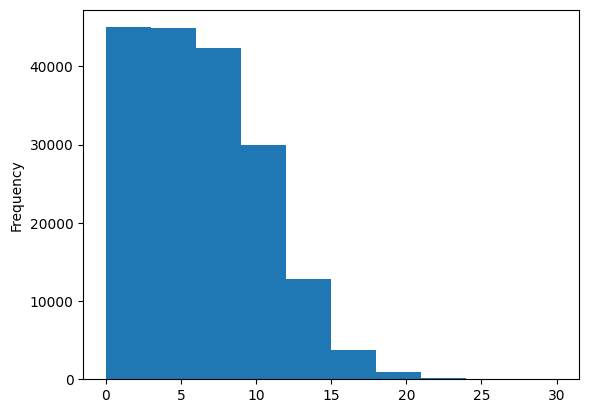

In [ ]:
#Chekc the distribution of "line_number" column
train_df.line_number.plot.hist()

In [ ]:
#Use tensorflow to create one-hot-encoded tensor of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [ ]:
#How many different lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

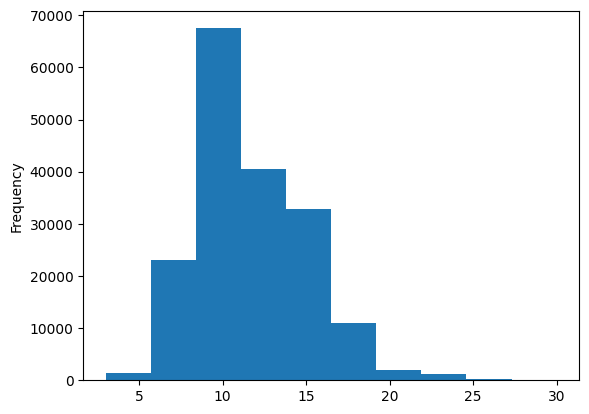

In [ ]:
#Check the distriv=butions of total lines
train_df.total_lines.plot.hist();

In [ ]:
#Check the coverage of total_lines value of 20
np.percentile(train_df.total_lines,98)

20.0

In [ ]:
#Use tensorflow to create one hot encoded tensor of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

###Building a tribrid embedding model

1. Create a token-level model.
2. Create a character-level model.
3. Create a model for the "line_number" feature.
4. Create a model for the "total_lines" feature.
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate.
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate.
7. Create an output layer to accept the tribried embedding and output label probabilities.
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model.

In [ ]:
# 1. Token Inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char Inputs
char_inputs = layers.Input(shape=(1,),dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Create a model fot the "line_number" feature
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_inputs")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_line_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                             char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combained token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kids of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs = output_layer,
                         name="model_5_tribrid_embedding_model")

In [ ]:
#Summary
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

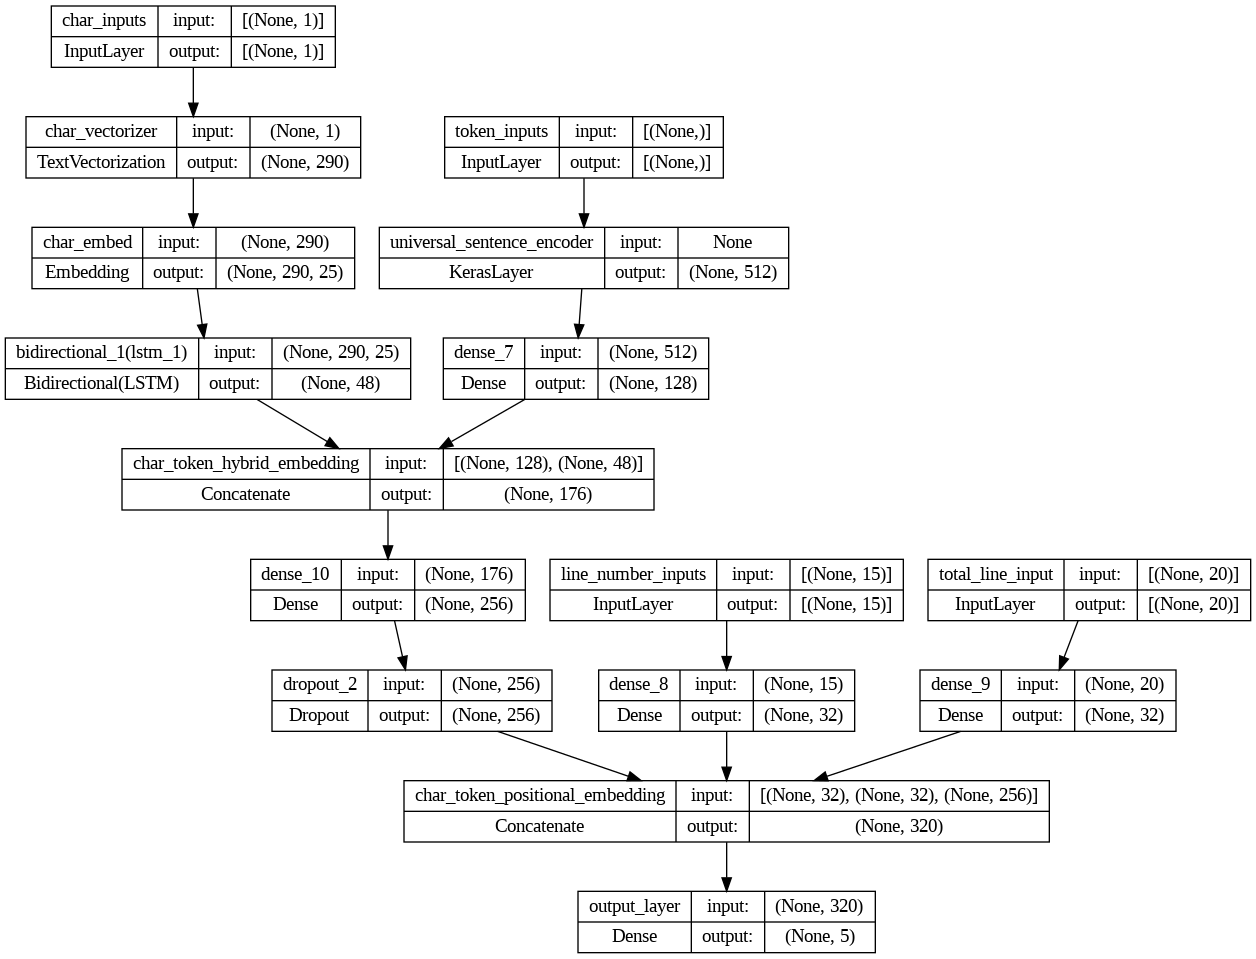

In [ ]:
#Ploting model_5
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [ ]:
# Compile token, char and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
               optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

###Creating Tribrid embedding datasets using tf.data

In [ ]:
# create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                               train_total_lines_one_hot,
                                                               train_sentences,
                                                               train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                               val_total_lines_one_hot,
                                                               val_sentences,
                                                               val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
#check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

##Fitting, Evaluating and making predictions with our tribrid model

In [ ]:
#Fit our tribrid model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch = int(0.1*len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data = val_char_token_pos_dataset,
                              validation_steps = int(0.1*len(val_char_token_pos_dataset)))


Epoch 1/3
562/562 [==============================] - 28s 51ms/step - loss: 0.9404 - accuracy: 0.8311 - val_loss: 0.9297 - val_accuracy: 0.8394
Epoch 2/3
562/562 [==============================] - 30s 53ms/step - loss: 0.9245 - accuracy: 0.8470 - val_loss: 0.9218 - val_accuracy: 0.8484
Epoch 3/3
562/562 [==============================] - 25s 45ms/step - loss: 0.9187 - accuracy: 0.8476 - val_loss: 0.9244 - val_accuracy: 0.8411


In [ ]:
#Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 19s 20ms/step


array([[0.51971185, 0.1035696 , 0.01106819, 0.34848595, 0.01716437],
       [0.5498126 , 0.10659735, 0.04619784, 0.2879345 , 0.00945766],
       [0.29764318, 0.09987261, 0.10978071, 0.42080083, 0.07190267],
       ...,
       [0.03710223, 0.10207218, 0.03653375, 0.03184905, 0.7924428 ],
       [0.02892704, 0.3579489 , 0.07625804, 0.02803938, 0.5088266 ],
       [0.10899232, 0.7692754 , 0.05490217, 0.03089141, 0.03593861]],
      dtype=float32)

In [ ]:
#convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculates results of char token pos model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred = model_5_preds)
model_5_results

{'accuracy': 84.26453065007283,
 'precision': 0.8416863232419902,
 'recall': 0.8426453065007282,
 'f1': 0.8414343667106116}

##Compare Model Results

In [ ]:
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.674037,0.784102,0.786740,0.784391
model_2_pretrained_token_embedding,71.405402,0.714351,0.714054,0.711138
model_3_custom_char_embedding,64.381703,0.634341,0.643817,0.633031
model_4_hybrid_char_token_embedding,73.596584,0.736781,0.735966,0.734794
model_5_pos_char_token_embedding,84.264531,0.841686,0.842645,0.841434


In [ ]:
#REsuce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

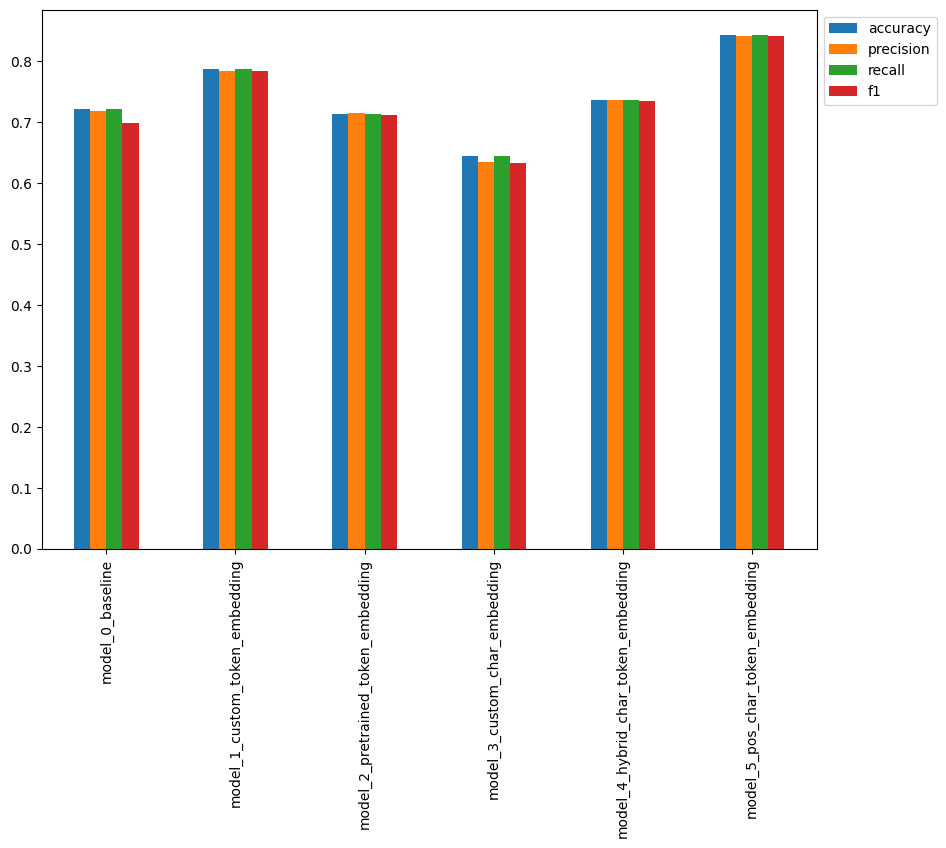

In [ ]:
#Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

<Axes: >

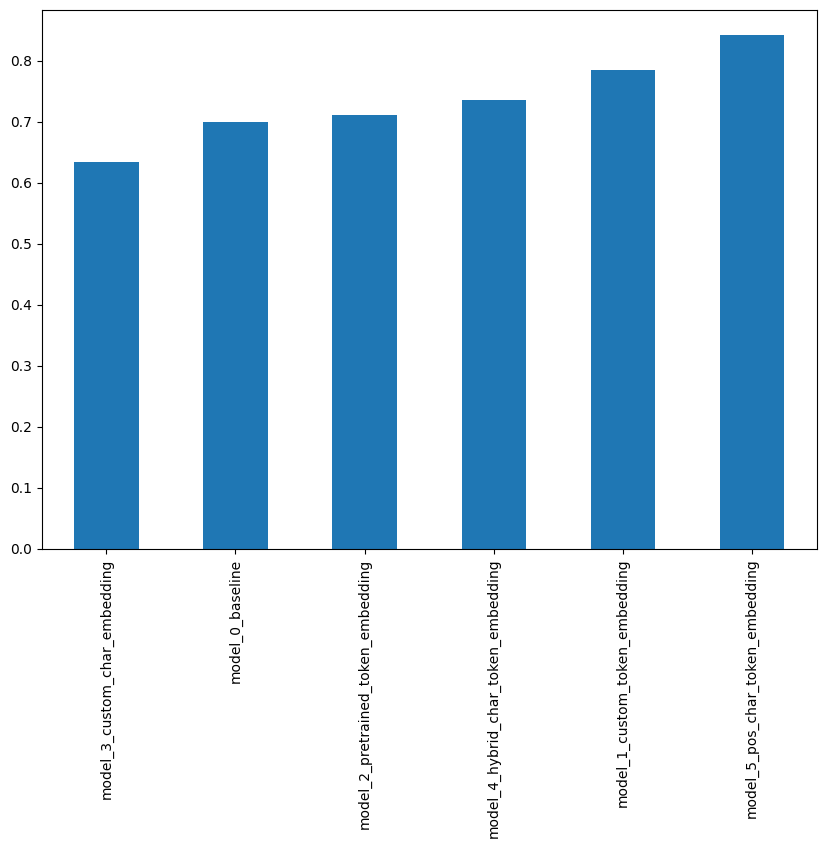

In [ ]:
# sort all models results byf1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10,7))

In [ ]:
T